In [1]:
import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc


import uproot 
import awkward as ak

In [12]:
file = "/home/dejavu/Projects/qgcal/Training/bdt_sample.npy"
X = np.load(file)

In [10]:
nevents = 100000
y = np.concatenate((np.zeros(nevents), 1.0 * np.ones(nevents)))

In [13]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [14]:
import pickle
filename = 'bdt_model.sav'
bdt = pickle.load(open(filename, 'rb'))

In [27]:
y_test_decisions = bdt.decision_function(X_test[:,:5])

In [28]:
scores = np.concatenate((X_test[:,:6], y_test_decisions[:,None]), axis = 1)

In [20]:
features_name = ["jet_pt", "jet_eta", "jet_nTracks", "jet_trackWidth", "jet_trackC1", "jet_trackBDT", "New_Training"]
features_name = np.array(features_name)

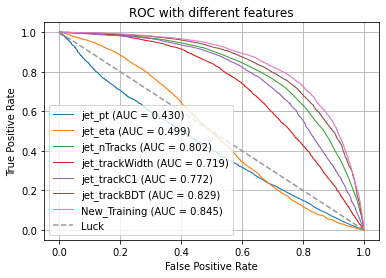

In [31]:
from sklearn.metrics import classification_report, roc_auc_score
for i in range(7):
    fpr, tpr, thresholds = roc_curve(y_test, scores[:,i], sample_weight = X_test[:,-1])
    roc_auc = auc(fpr, tpr)
    plt.plot(1-fpr, tpr, lw=1, label= features_name[i]+ ' (AUC = %0.3f)'%(roc_auc))

plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC with different features')
plt.legend(loc="lower left")
plt.grid()
plt.savefig("ROC_all_feat")
plt.show()

## Grid Search

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn import model_selection 


dt = DecisionTreeClassifier(max_depth=5,
                            min_samples_leaf=0.001,
                            max_features="auto")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=600,
                         learning_rate=0.5)

In [33]:
# Perform grid search over all combinations
# of these hyper-parameters
param_grid = {"base_estimator__max_depth": [3, 5, 7],
              "n_estimators": [50,200,400,750, 1000],
              'learning_rate': [0.001, 0.01, 0.1, 1.]}

In [34]:
clf = model_selection.GridSearchCV(bdt,
                               param_grid,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=8,
                               verbose=4)
_ = clf.fit(X_dev[:,:5], y_dev)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=50;, score=0.804 total time=   7.6s
[CV 2/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=50;, score=0.810 total time=   8.4s
[CV 3/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=50;, score=0.808 total time=   9.3s
[CV 1/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=200;, score=0.813 total time=  31.6s
[CV 3/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=200;, score=0.810 total time=  34.5s
[CV 2/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=200;, score=0.813 total time=  36.1s
[CV 1/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=400;, score=0.817 total time= 1.2min
[CV 2/3] END base_estimator__max_depth=3, learning_rate=0.001, n_estimators=400;, score=0.815 total time= 1.2min
[CV 3/3] END base_estimator__max_dept

KeyboardInterrupt: 